In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage

from amadeus import Client, ResponseError
from amadeus import Location

from typing_extensions import TypedDict
from typing import Annotated

import requests

from dotenv import load_dotenv 
load_dotenv()

import os

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
def get_flight_details(originLocation: str, distinationLocation: str, date: str, adults: int):
    '''This function provide the details of the flights'''

    amadeus_flight = Client()

    response = amadeus_flight.shopping.flight_offers_search.get(
        originLocationCode=originLocation,
        destinationLocationCode=distinationLocation,
        departureDate=date,
        adults=adults
    )

    return response.data[0:2]

def get_airport_code(city:str):
    '''This function provide the airport code based on given city'''

    amadues_code = Client()
    
    code_repoonse = amadues_code.reference_data.locations.get(keyword='LON', subType=Location.ANY)

    return code_repoonse


def curreny_converter(base_curreny:str, target_currency:str):
    '''this function convert curreny from EUR(base currency) to INR(target curreny)'''

    url_currency = f"https://v6.exchangerate-api.com/v6/2daabdcbf5800f70d4db2aef/pair/{base_curreny}/{target_currency}"

    currency_response = requests.get(url=url_currency)
    
    return currency_response.json()

In [4]:
def collect_user_information(name: str, age: int, emailID: str):
    '''This function collect the user information for booking the flight'''
    return {'messages': f"name is {name}, age is {age}, emailID is {emailID}"}

In [5]:
def book_flight_comfirmation(state: State):
    '''This function give the final confirmation of flight booking'''
    return { 'messages': AIMessage(content="Your flight has been booked successfully!") }

In [6]:
llm = ChatOpenAI()

tools = [get_flight_details,get_airport_code,curreny_converter,collect_user_information,book_flight_comfirmation]

llm_with_tools = llm.bind_tools(tools=tools)

In [7]:
def planner_chatbot(state: State):
    return {"messages": llm_with_tools.invoke(state['messages']) }

In [8]:
graph_builder = StateGraph(State)

graph_builder.add_node('planner_chatbot',planner_chatbot)
graph_builder.add_node('tools',ToolNode(tools=tools))

graph_builder.add_edge(START,"planner_chatbot")
graph_builder.add_conditional_edges("planner_chatbot",tools_condition)
graph_builder.add_edge("tools","planner_chatbot")

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

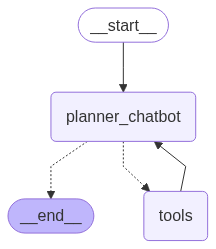

In [9]:
from IPython.display import display,Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
config = {'configurable':{'thread_id':"1"}}

In [11]:
response = graph.invoke({"messages":"my name is deepak pawar"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

my name is deepak pawar
================================== Ai Message ==================================

Hello Deepak Pawar! How can I assist you today?


In [13]:
response['messages']

[HumanMessage(content='my name is deepak pawar', additional_kwargs={}, response_metadata={}, id='3aeb2915-df32-42f6-a102-1aabebf40e7a'),
 AIMessage(content='Hello Deepak Pawar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 211, 'total_tokens': 225, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bmh2aK17XFBIXLreQZ5hyifUSVoiP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b5b9e858-bf1d-4ee3-8ddd-0b9da4b795a6-0', usage_metadata={'input_tokens': 211, 'output_tokens': 14, 'total_tokens': 225, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [12]:
config = {'configurable':{'thread_id':"2"}}

In [14]:
response = graph.invoke({"messages":"what is my name?"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is my name?
================================== Ai Message ==================================

I'm sorry, but I don't have access to your personal information. How can I assist you today?


In [15]:
response['messages']

[HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='5c1da06e-5a57-4e6a-a798-b8aa3295c299'),
 AIMessage(content="I'm sorry, but I don't have access to your personal information. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 209, 'total_tokens': 232, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bmh3rWa22MSg8OcsWprnoayV0YPfo', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--846f2707-86e9-4c24-a50c-dcef456cf199-0', usage_metadata={'input_tokens': 209, 'output_tokens': 23, 'total_tokens': 232, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reaso

In [56]:
response = graph.invoke({"messages":"i want to book from delhi to mumbai for 7th July 2025"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to book flight tickets
================================== Ai Message ==================================

Great! I can help you with that. Could you please provide me with the details like the origin location, destination location, date of travel, and the number of adults traveling?
================================ Human Message =================================

i want to book from delhi to mumbai for 7th July 2025
================================== Ai Message ==================================

Perfect! Could you please confirm the number of adults traveling on this trip?


In [57]:
response['messages']

[HumanMessage(content='I want to book flight tickets', additional_kwargs={}, response_metadata={}, id='d1344614-cae5-4d87-a789-9c9dcdff444a'),
 AIMessage(content='Great! I can help you with that. Could you please provide me with the details like the origin location, destination location, date of travel, and the number of adults traveling?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 210, 'total_tokens': 247, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Blr6BjpHAxDGmhDOfxp7nkrJlUMPd', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--091695fe-d5bc-4ba7-a06b-dff51e0ed1da-0', usage_metadata={'input_tokens': 210, 'output_tokens': 37, 'total_tokens': 247,

In [43]:
response = graph.invoke({"messages":"I want to book flight number 2"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to book flight tickets
================================== Ai Message ==================================

Sure, I can assist you with booking flight tickets. Could you please provide me with the following details:
1. Your origin location (city or airport)
2. Your destination location (city or airport)
3. Date of travel
4. Number of adults travelling

Once you provide me with these details, I can proceed with checking the available flights for you.
================================ Human Message =================================

i want to book from delhi to mumbai for 7th July 2025
================================== Ai Message ==================================
Tool Calls:
  get_airport_code (call_iCyokd8p8eTJxR0uwgmeEWjm)
 Call ID: call_iCyokd8p8eTJxR0uwgmeEWjm
  Args:
    city: Delhi
================================= Tool Message =================================
Name: get_airport_code

===========

In [15]:
response = graph.invoke({"messages":"My name is Deepak Pawar and age is 29. My email ID is abc@gmail.com"},config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to book flight tickets
================================== Ai Message ==================================

Sure, I can assist you with booking flight tickets. Could you please provide me with the details like your origin location, destination location, date of travel, and the number of adults traveling?
================================ Human Message =================================

i want to book from delhi to mumbai for 7th July 2025
================================== Ai Message ==================================
Tool Calls:
  get_airport_code (call_ZV9S4fC9vDRSgjeLnCzjXEZS)
 Call ID: call_ZV9S4fC9vDRSgjeLnCzjXEZS
  Args:
    city: Delhi
================================= Tool Message =================================
Name: get_airport_code

================================== Ai Message ==================================
Tool Calls:
  get_airport_code (call_Q5YCt2GUYsLcEv6GvDeQiatA)
 Call ID: call_